In [1]:
set.seed(1234)

library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)

devtools::load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory materia

In [4]:
#bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Ufusca/v1.1/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/urochlea_fusca.snake/03.bed_files_merged/"

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"annotation/Ufusca_669_v1.1.gene.gff3")
chr <- paste0(reference_genome_path,"assembly/Ufusca_669_v1.0.chrom.size")

#output_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusca/"
#output_path_imgs <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusca/QC_output/imgs/"

pre <- "urochloa_subclusteing"
urochloa_fusca.rep1 <- paste0(analysis_path, "urochlea_fusca.filter.mpq_10.rmdup.unique.sorted.bed")

print(urochloa_fusca.rep1)
#Load Object
urochloa_fusca.leaf.rep1 <- loadBEDandGenomeData(urochloa_fusca.rep1, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

[1] "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/urochlea_fusca.snake/03.bed_files_merged/urochlea_fusca.filter.mpq_10.rmdup.unique.sorted.bed"


Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/urochlea_fusca.snake/03.bed_files_merged/urochlea_fusca.filter.mpq_10.rmdup.unique.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Ufusca/v1.1/annotation/Ufusca_669_v1.1.gene.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Ufusca/v1.1/assembly/Ufusca_669_v1.0.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [19]:
library(tidyverse)
marker_list_uf_file <- "/home/jpm73279/genome_downloads/Ufusca/markers_2023-04-18/Uf.combined_known_de_novo_markers.visualize.txt"
marker_list_uf <- read_delim(marker_list_uf_file, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

loaded_socrates_data <- read.table("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/clustering/Uf_leaf.merged_replicates.SVD.full.metadata.txt")

Rows: 540 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): chr, start, stop, geneID, gene_name, cell_type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [20]:
uf.subcluster <- urochloa_fusca.leaf.rep1


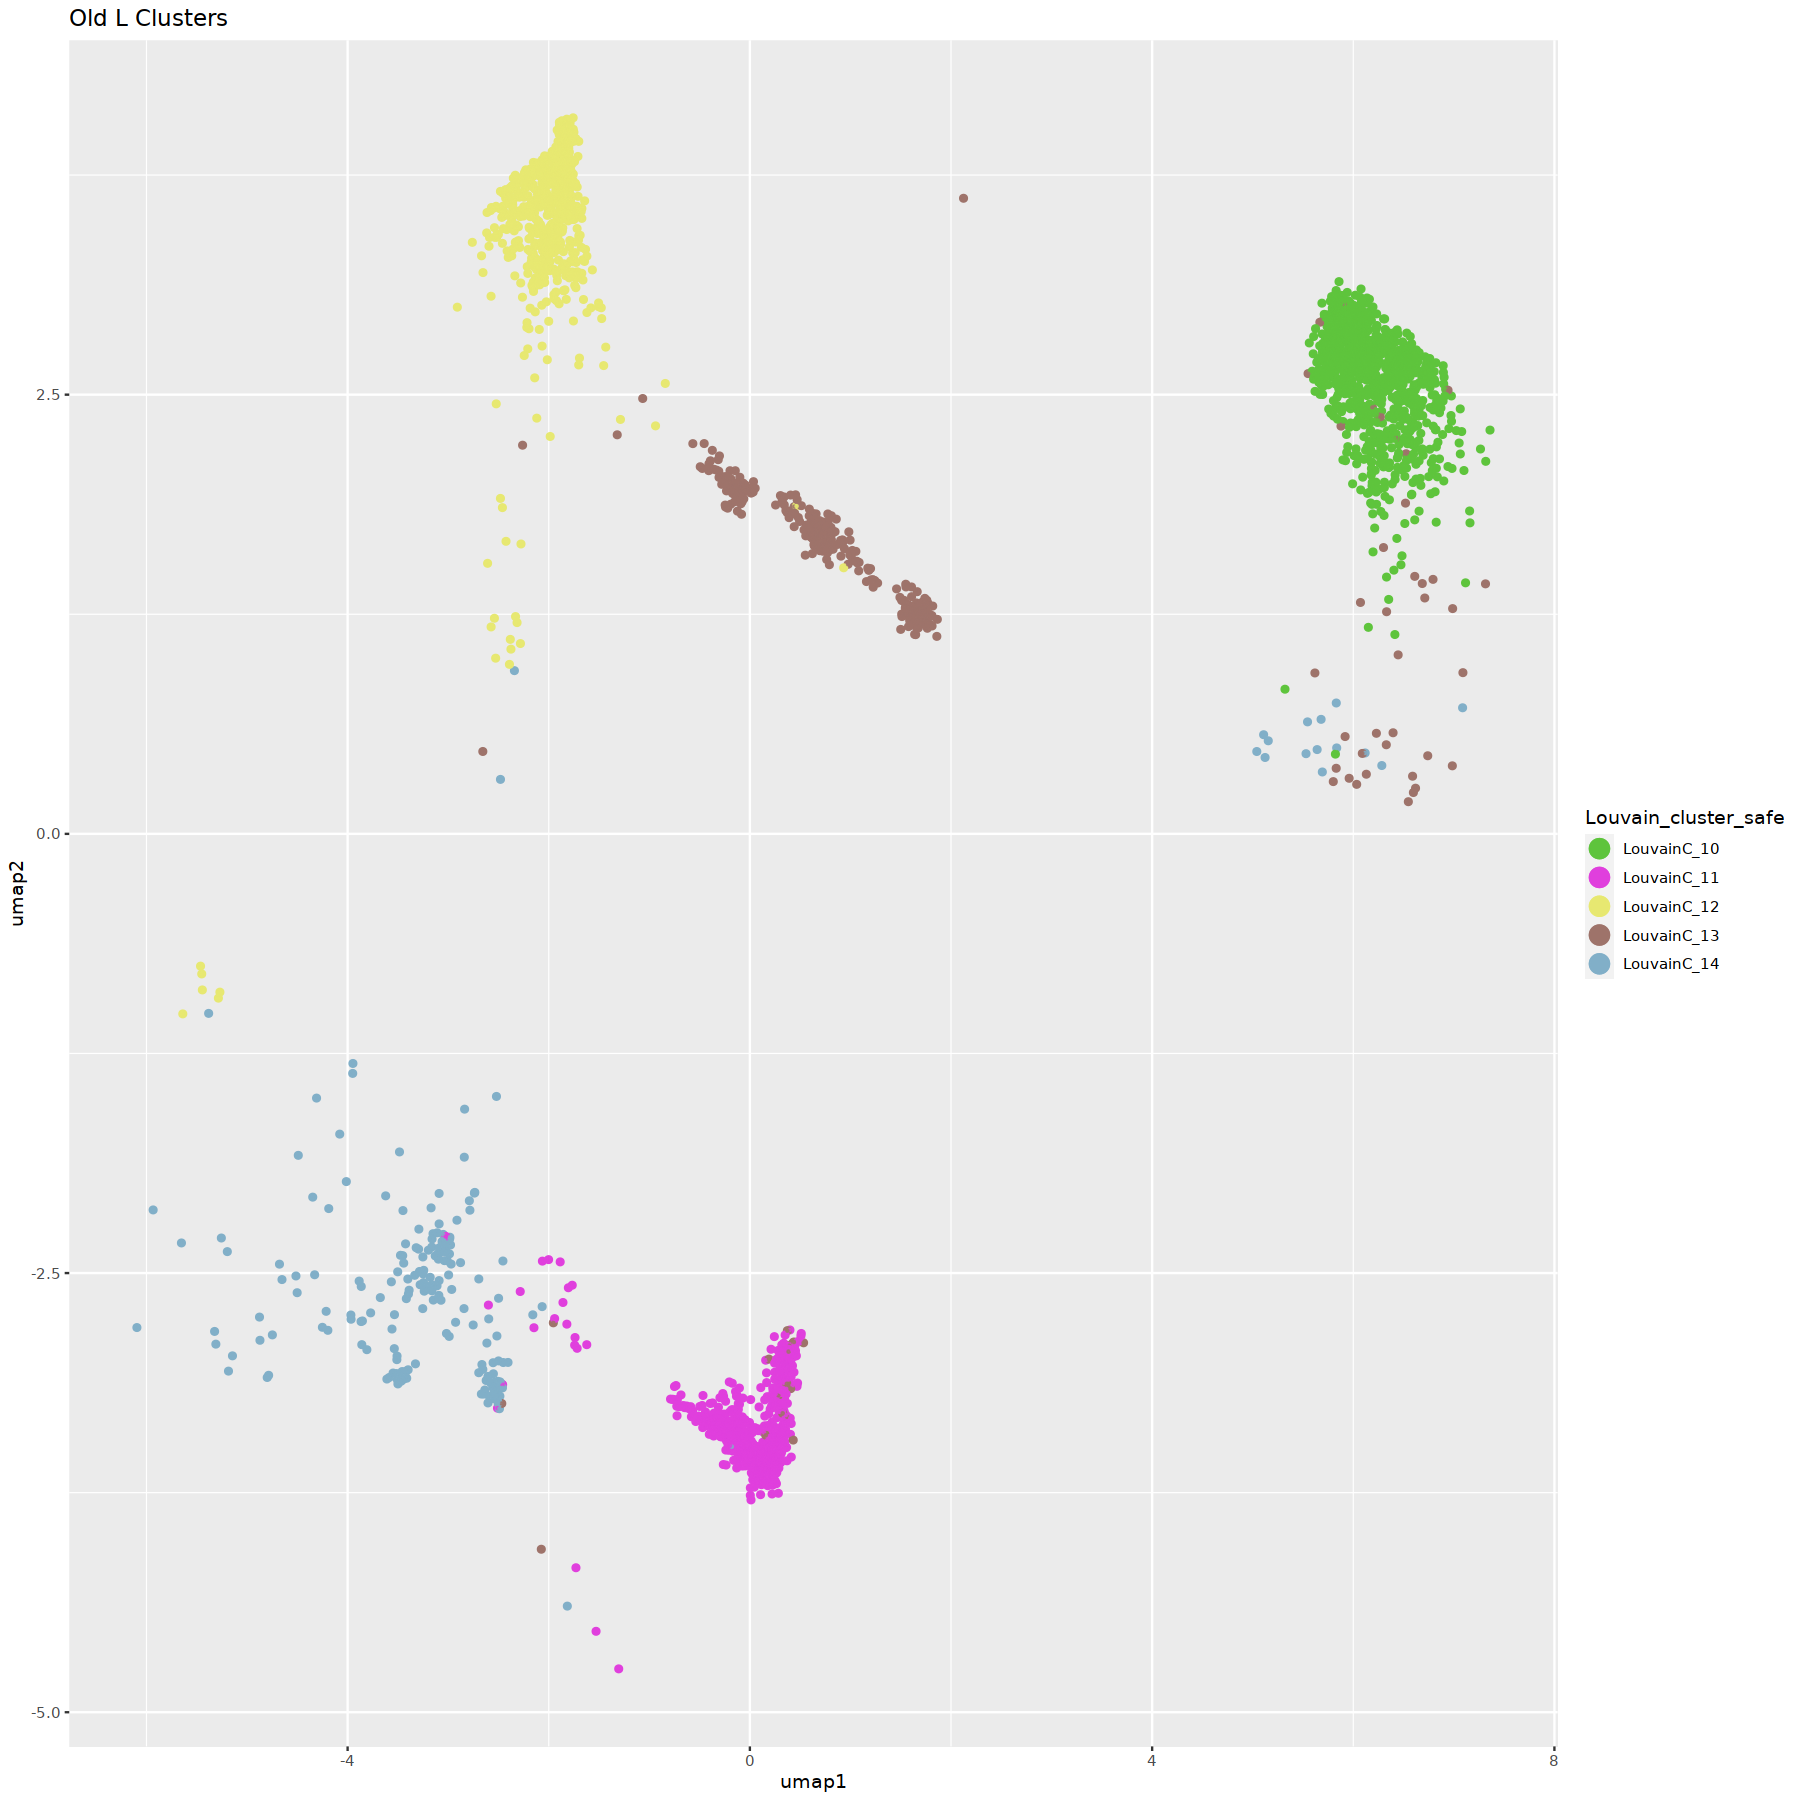

In [73]:
cleaned_cluster_meta <- loaded_socrates_data  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    


## SubClustering Unknown vascular Lineages:

library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


#uf.subcluster <- uf.loaded_socrates_data
clusters <- c("LouvainC_10", "LouvainC_11","LouvainC_12","LouvainC_13","LouvainC_14")


cleaned_cluster_meta  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

In [24]:
chosen_subcluster <- cleaned_cluster_meta %>% 
    filter(Louvain_cluster_safe %in% clusters)  %>% 
    ungroup()
str(chosen_subcluster)

tibble [4,840 × 24] (S3: tbl_df/tbl/data.frame)
 $ cellID              : chr [1:4840] "BC:Z:GATCAGGGCTACAGCGAGAGTGGACCGG-urochlea_fusca.P7_10x.1" "BC:Z:TGACCAATGTCACATCTATTCCTACTAA-urochlea_fusca.P2_10x.1" "BC:Z:GCCAATATGTCATTACTACTGATTCGGA-urochlea_fusca.P4_10x.1" "BC:Z:CGATGTATGTCATCCCTGTAGAGTCATT-urochlea_fusca.T2_10x.1" ...
 $ total               : int [1:4840] 76720 134532 79064 100369 89967 105977 80247 56248 65156 48628 ...
 $ tss                 : int [1:4840] 25430 74088 28644 50764 45551 55688 42164 21673 34702 18221 ...
 $ acrs                : int [1:4840] 9900 81810 19632 52117 42667 59460 45508 14669 37550 11790 ...
 $ ptmt                : int [1:4840] 1280 413 3645 516 563 649 791 6134 761 3075 ...
 $ nSites              : int [1:4840] 42124 38929 38769 38454 37093 36293 29583 28526 26068 25003 ...
 $ log10nSites         : num [1:4840] 4.62 4.59 4.59 4.58 4.57 ...
 $ pTSS                : num [1:4840] 0.331 0.551 0.362 0.506 0.506 ...
 $ FRiP                : num [1:484

In [25]:
meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- chosen_subcluster$cellID

In [26]:
urochloa_fusca.leaf.rep1.subcluster <- urochloa_fusca.leaf.rep1

In [27]:
urochloa_fusca.leaf.rep1.subcluster$meta <- meta_df
urochloa_fusca.leaf.rep1.subcluster$meta.v3 <- meta_df

In [30]:
urochloa_fusca.leaf.rep1.subcluster <- generateMatrix(urochloa_fusca.leaf.rep1.subcluster, 
                                              filtered=FALSE,
                                blacklist="/home/jpm73279/genome_downloads/Ufusca/markers_2023-04-18/Uf.cell_cycle_orthos.markers.bed",
                                              windows=500,
                                              peaks = FALSE,
                                              verbose=TRUE)

In [31]:
urochloa_fusca.leaf.rep1.subcluster <- convertSparseData(urochloa_fusca.leaf.rep1.subcluster, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [40]:
# clean sparse counts matrix ---------------------------------------------
urochloa_fusca.leaf.rep1.subcluster.clean <- cleanData(urochloa_fusca.leaf.rep1.subcluster, 
                     min.t=0.04,  # minimum feature frequency across cells
                     max.t=0.1, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 3241 | peaks = 611605

   * Filtered: cells = 3120 | peaks = 25101



In [41]:
urochloa_fusca.leaf.rep1.subcluster.clean$meta  %>% 
    group_by(Louvain_cluster_safe)  %>% 
    summarise(n())
    

# normalize with TFIDF ---------------------------------------------------
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf <- tfidf(urochloa_fusca.leaf.rep1.subcluster.clean)

Louvain_cluster_safe,n()
<chr>,<int>
LouvainC_10,989
LouvainC_11,844
LouvainC_12,705
LouvainC_13,411
LouvainC_14,171


In [42]:
# project with NMF -------------------------------------------------------
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf <- reduceDims(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf,
                      method="SVD", 
                      n.pcs=50, 
                      svd_slotName="SVD")

# reduce to 2-dimensions with UMAP ---------------------------------------
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf <- projectUMAP(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.1,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

12:24:49 UMAP embedding parameters a = 1.577 b = 0.8951

12:24:49 Read 3120 rows and found 49 numeric columns

12:24:49 Using Annoy for neighbor search, n_neighbors = 30

12:24:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:24:50 Writing NN index file to temp file /tmp/RtmpGK4zN7/file1406749d967ae

12:24:50 Searching Annoy index using 16 threads, search_k = 3000

12:24:50 Annoy recall = 100%

12:24:54 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 30

12:24:58 Initializing from normalized Laplacian + noise (using irlba)

12:24:58 Commencing optimization for 500 epochs, with 146094 positive edges

12:25:15 Optimization finished



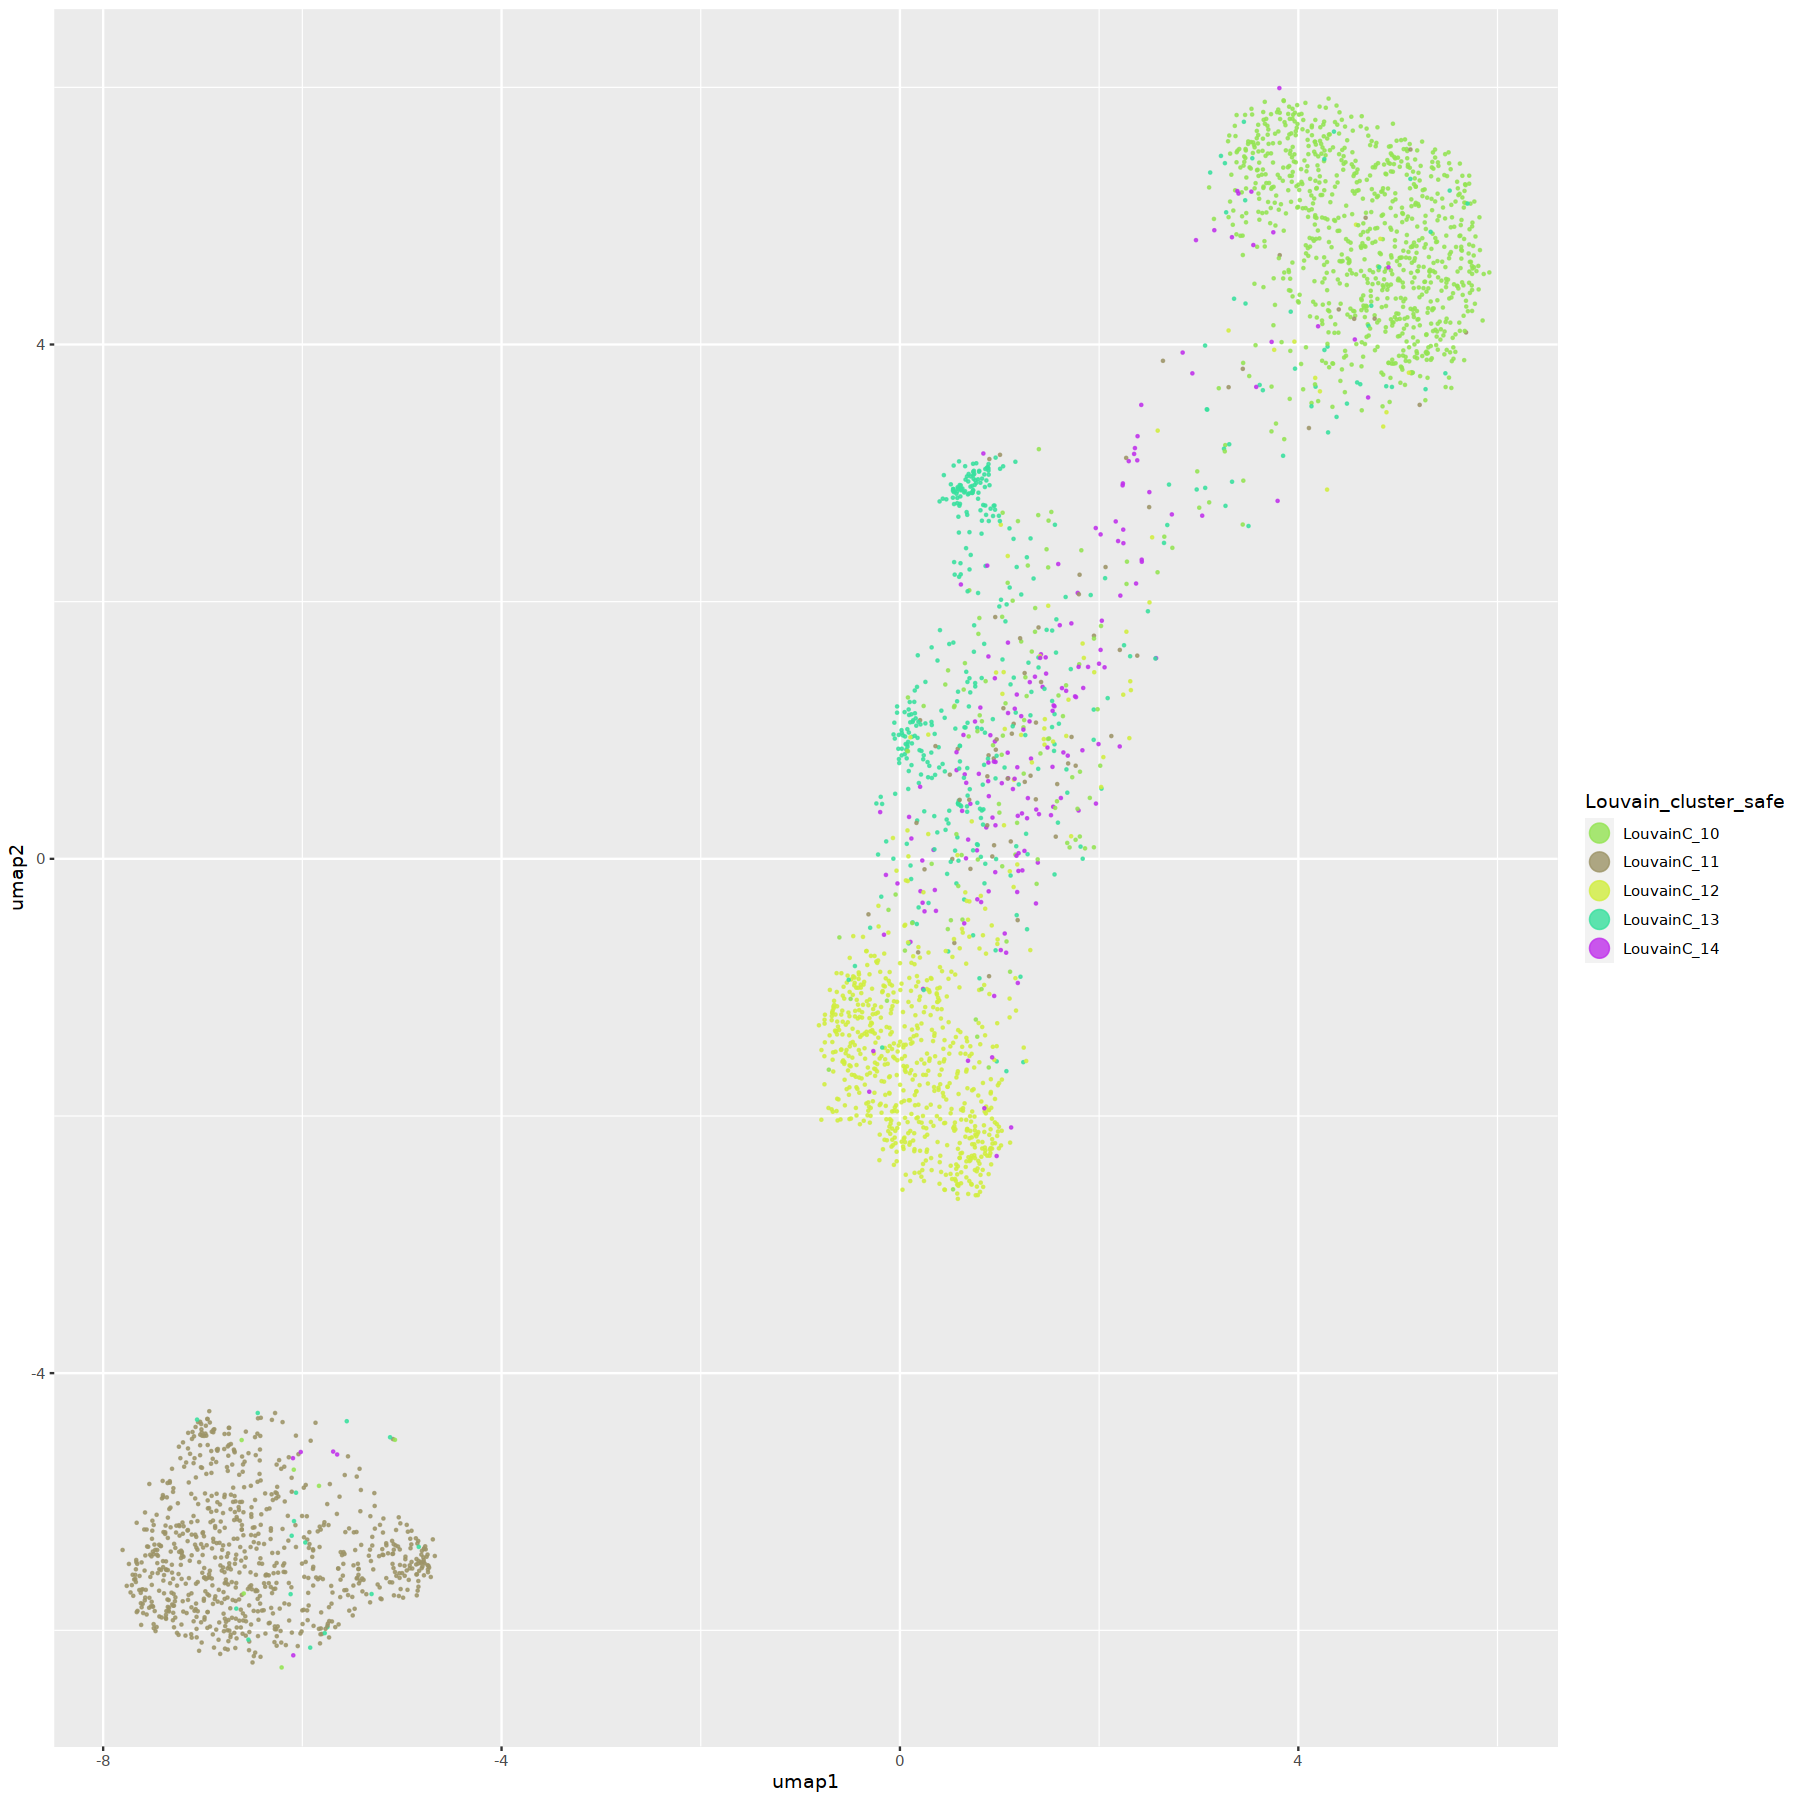

In [43]:
library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

ggplot(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf$meta, aes(x=umap1, y = umap2, color = Louvain_cluster_safe)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [49]:
# identify clusters using neighborhood graph -----------------------------
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters <- callClusters(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf, 
                        res=.75,
                        k.near = 30,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters$meta, aes(x=umap1, y = umap2, color = Louvain_cluster_safe)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3042
Number of edges: 241086

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7709
Number of communities: 7
Elapsed time: 2 seconds


1 singletons identified. 6 final clusters.

 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



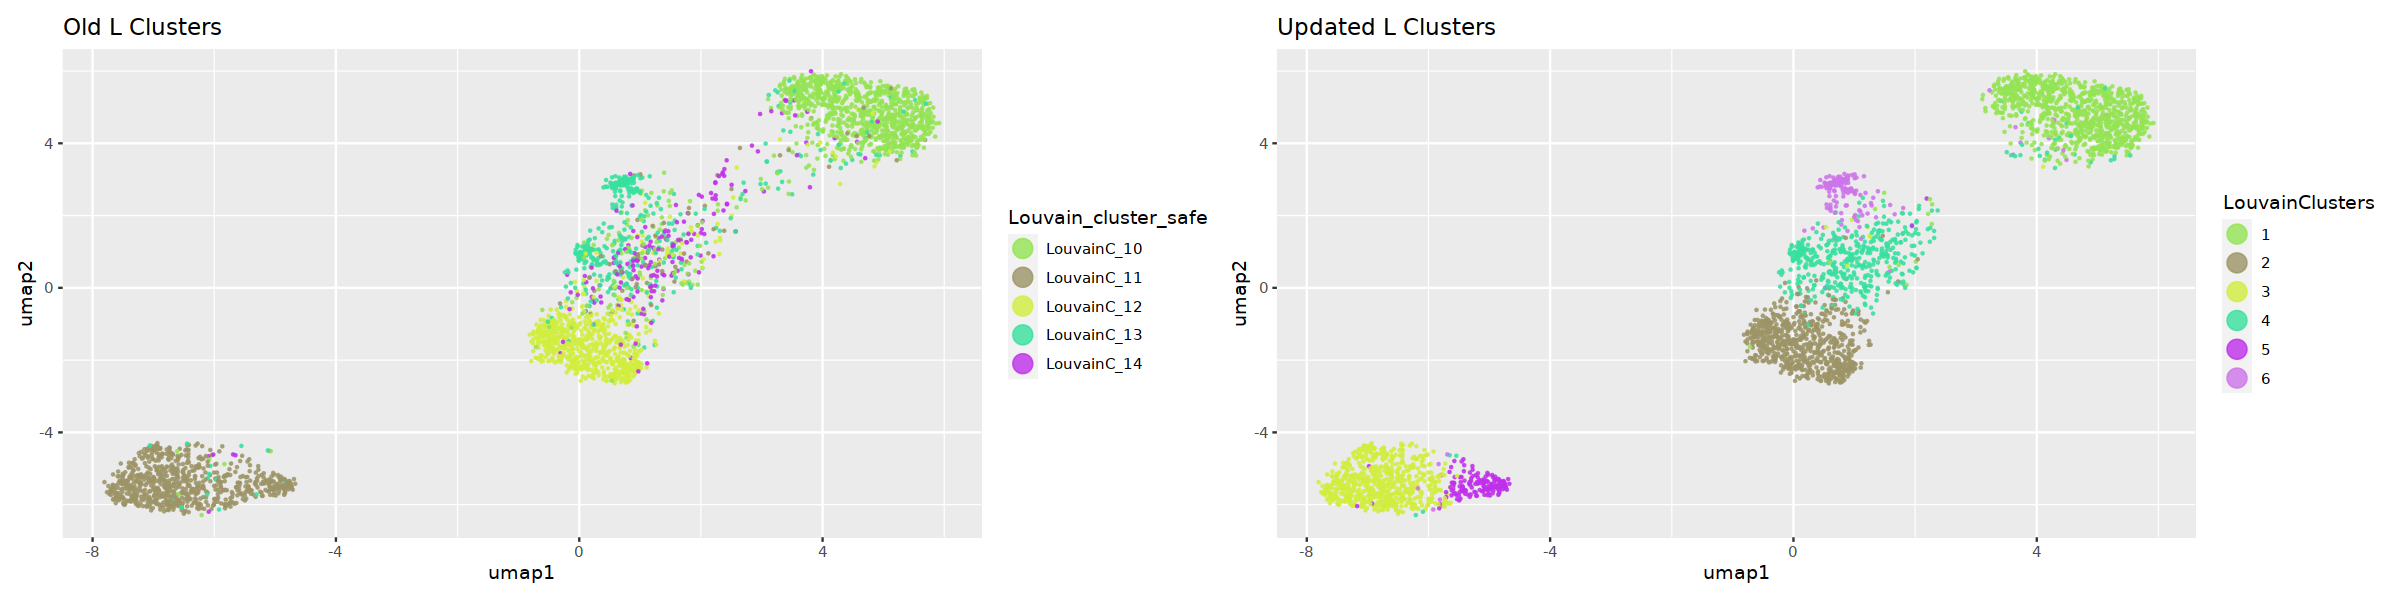

In [50]:
old_clusters + new_clusters 

In [51]:
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters$sub_cluster  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(n())

library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}

LouvainClusters,n()
<fct>,<int>
1,911
2,709
3,638
4,462
5,162
6,160


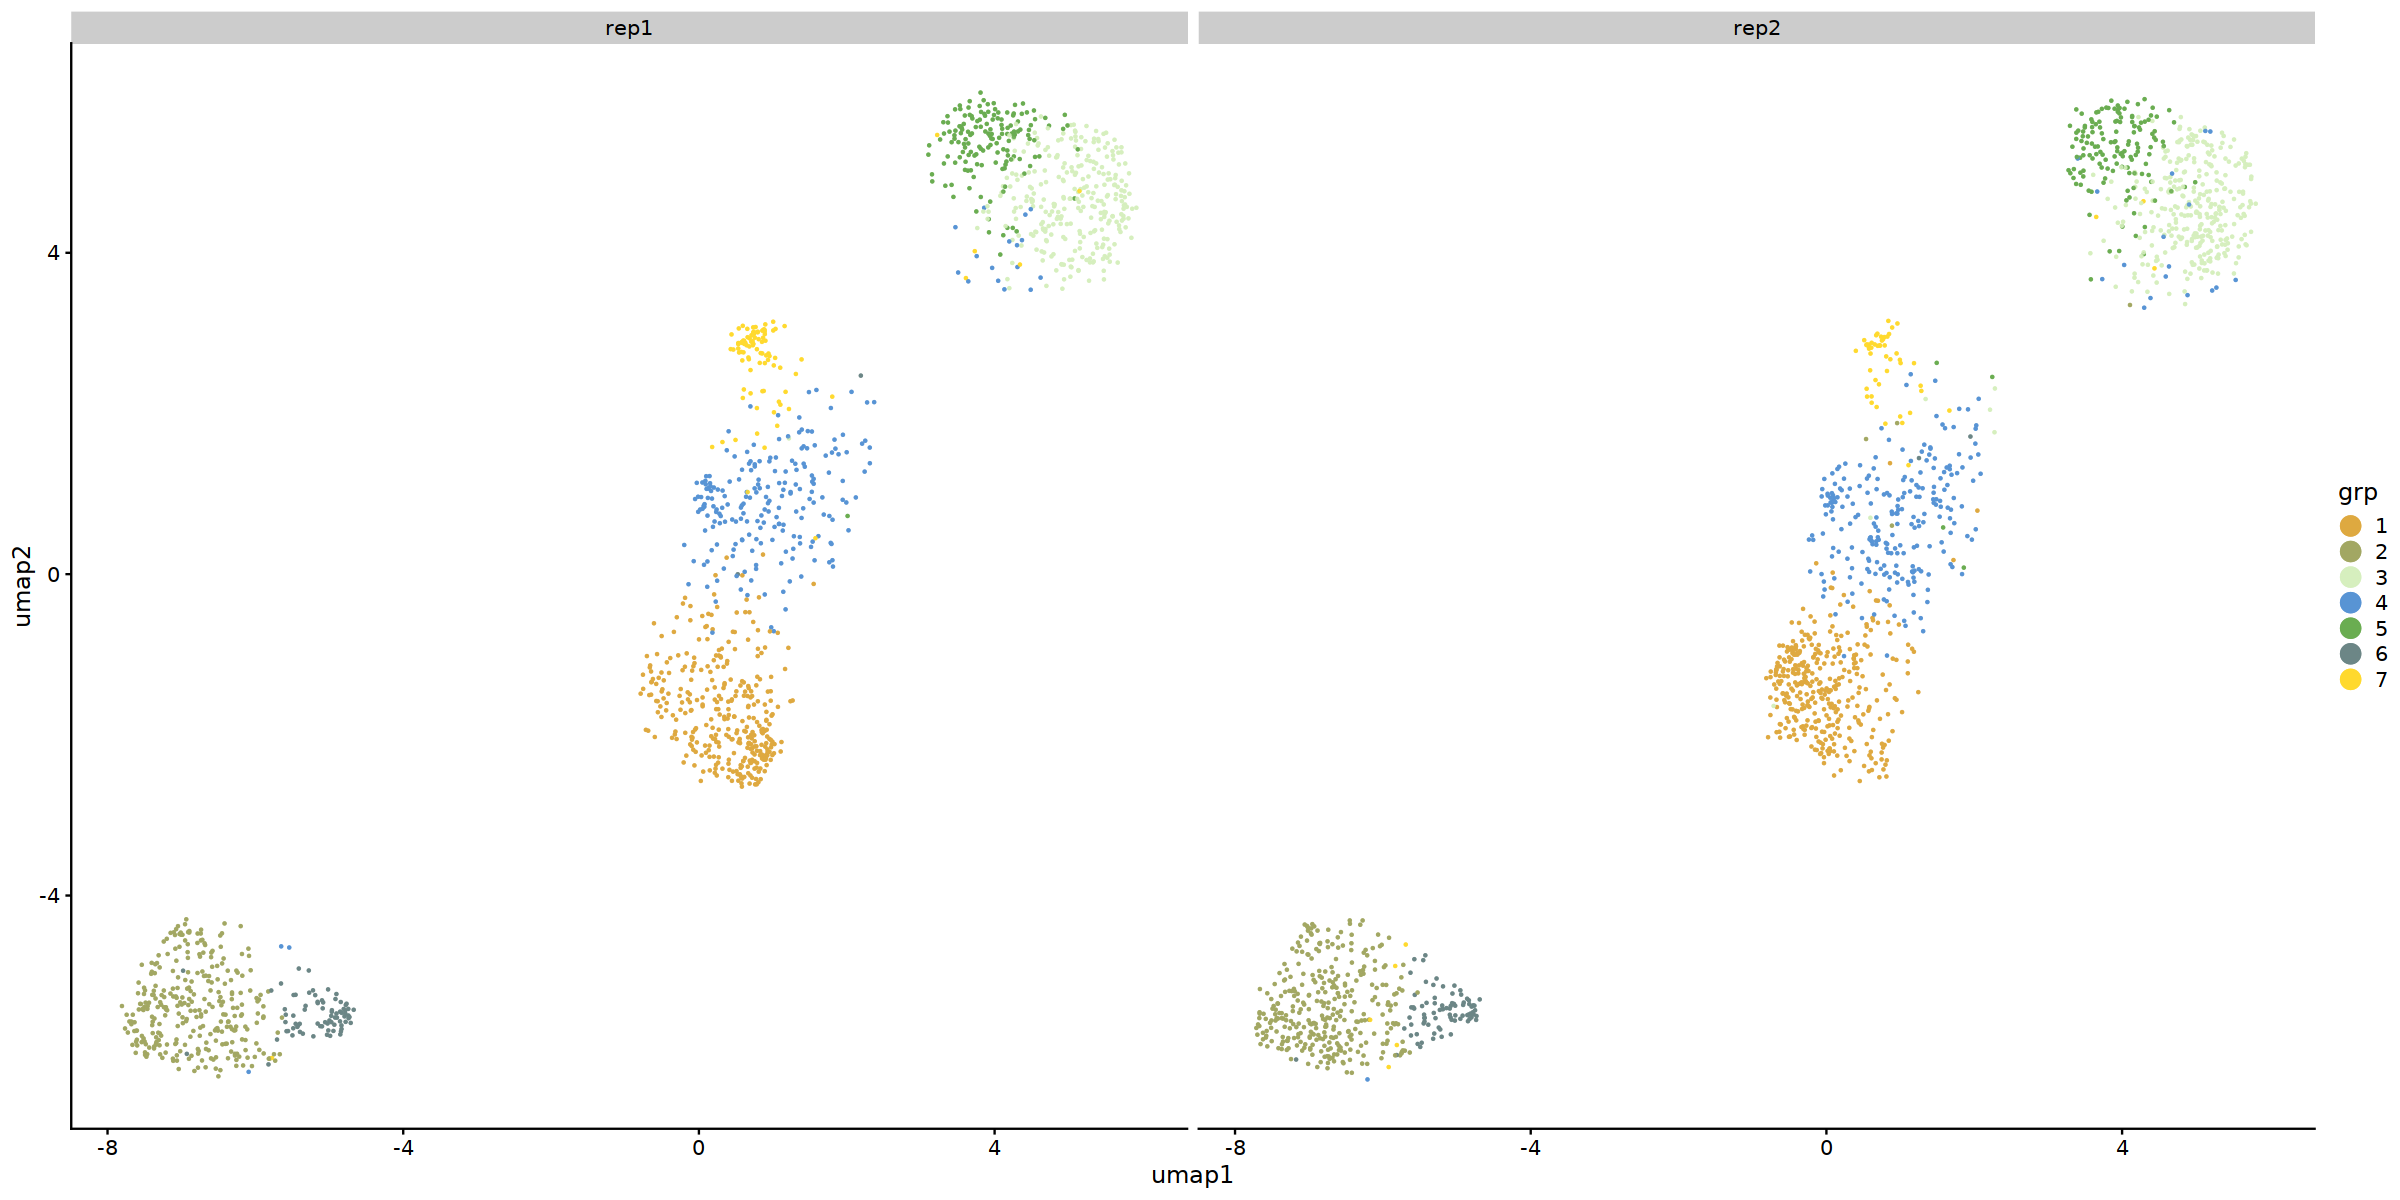

In [48]:
library(cowplot)
umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


col_scale <- scale_colour_manual(name = "grp", values = umap_cluster_colors)


options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters$sub_cluster)

ggplot(cluster_plot ,aes(umap1, umap2, color = LouvainClusters)) + 
    col_scale + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) + theme_half_open() +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    geom_point(size = .25, alpha = .8)


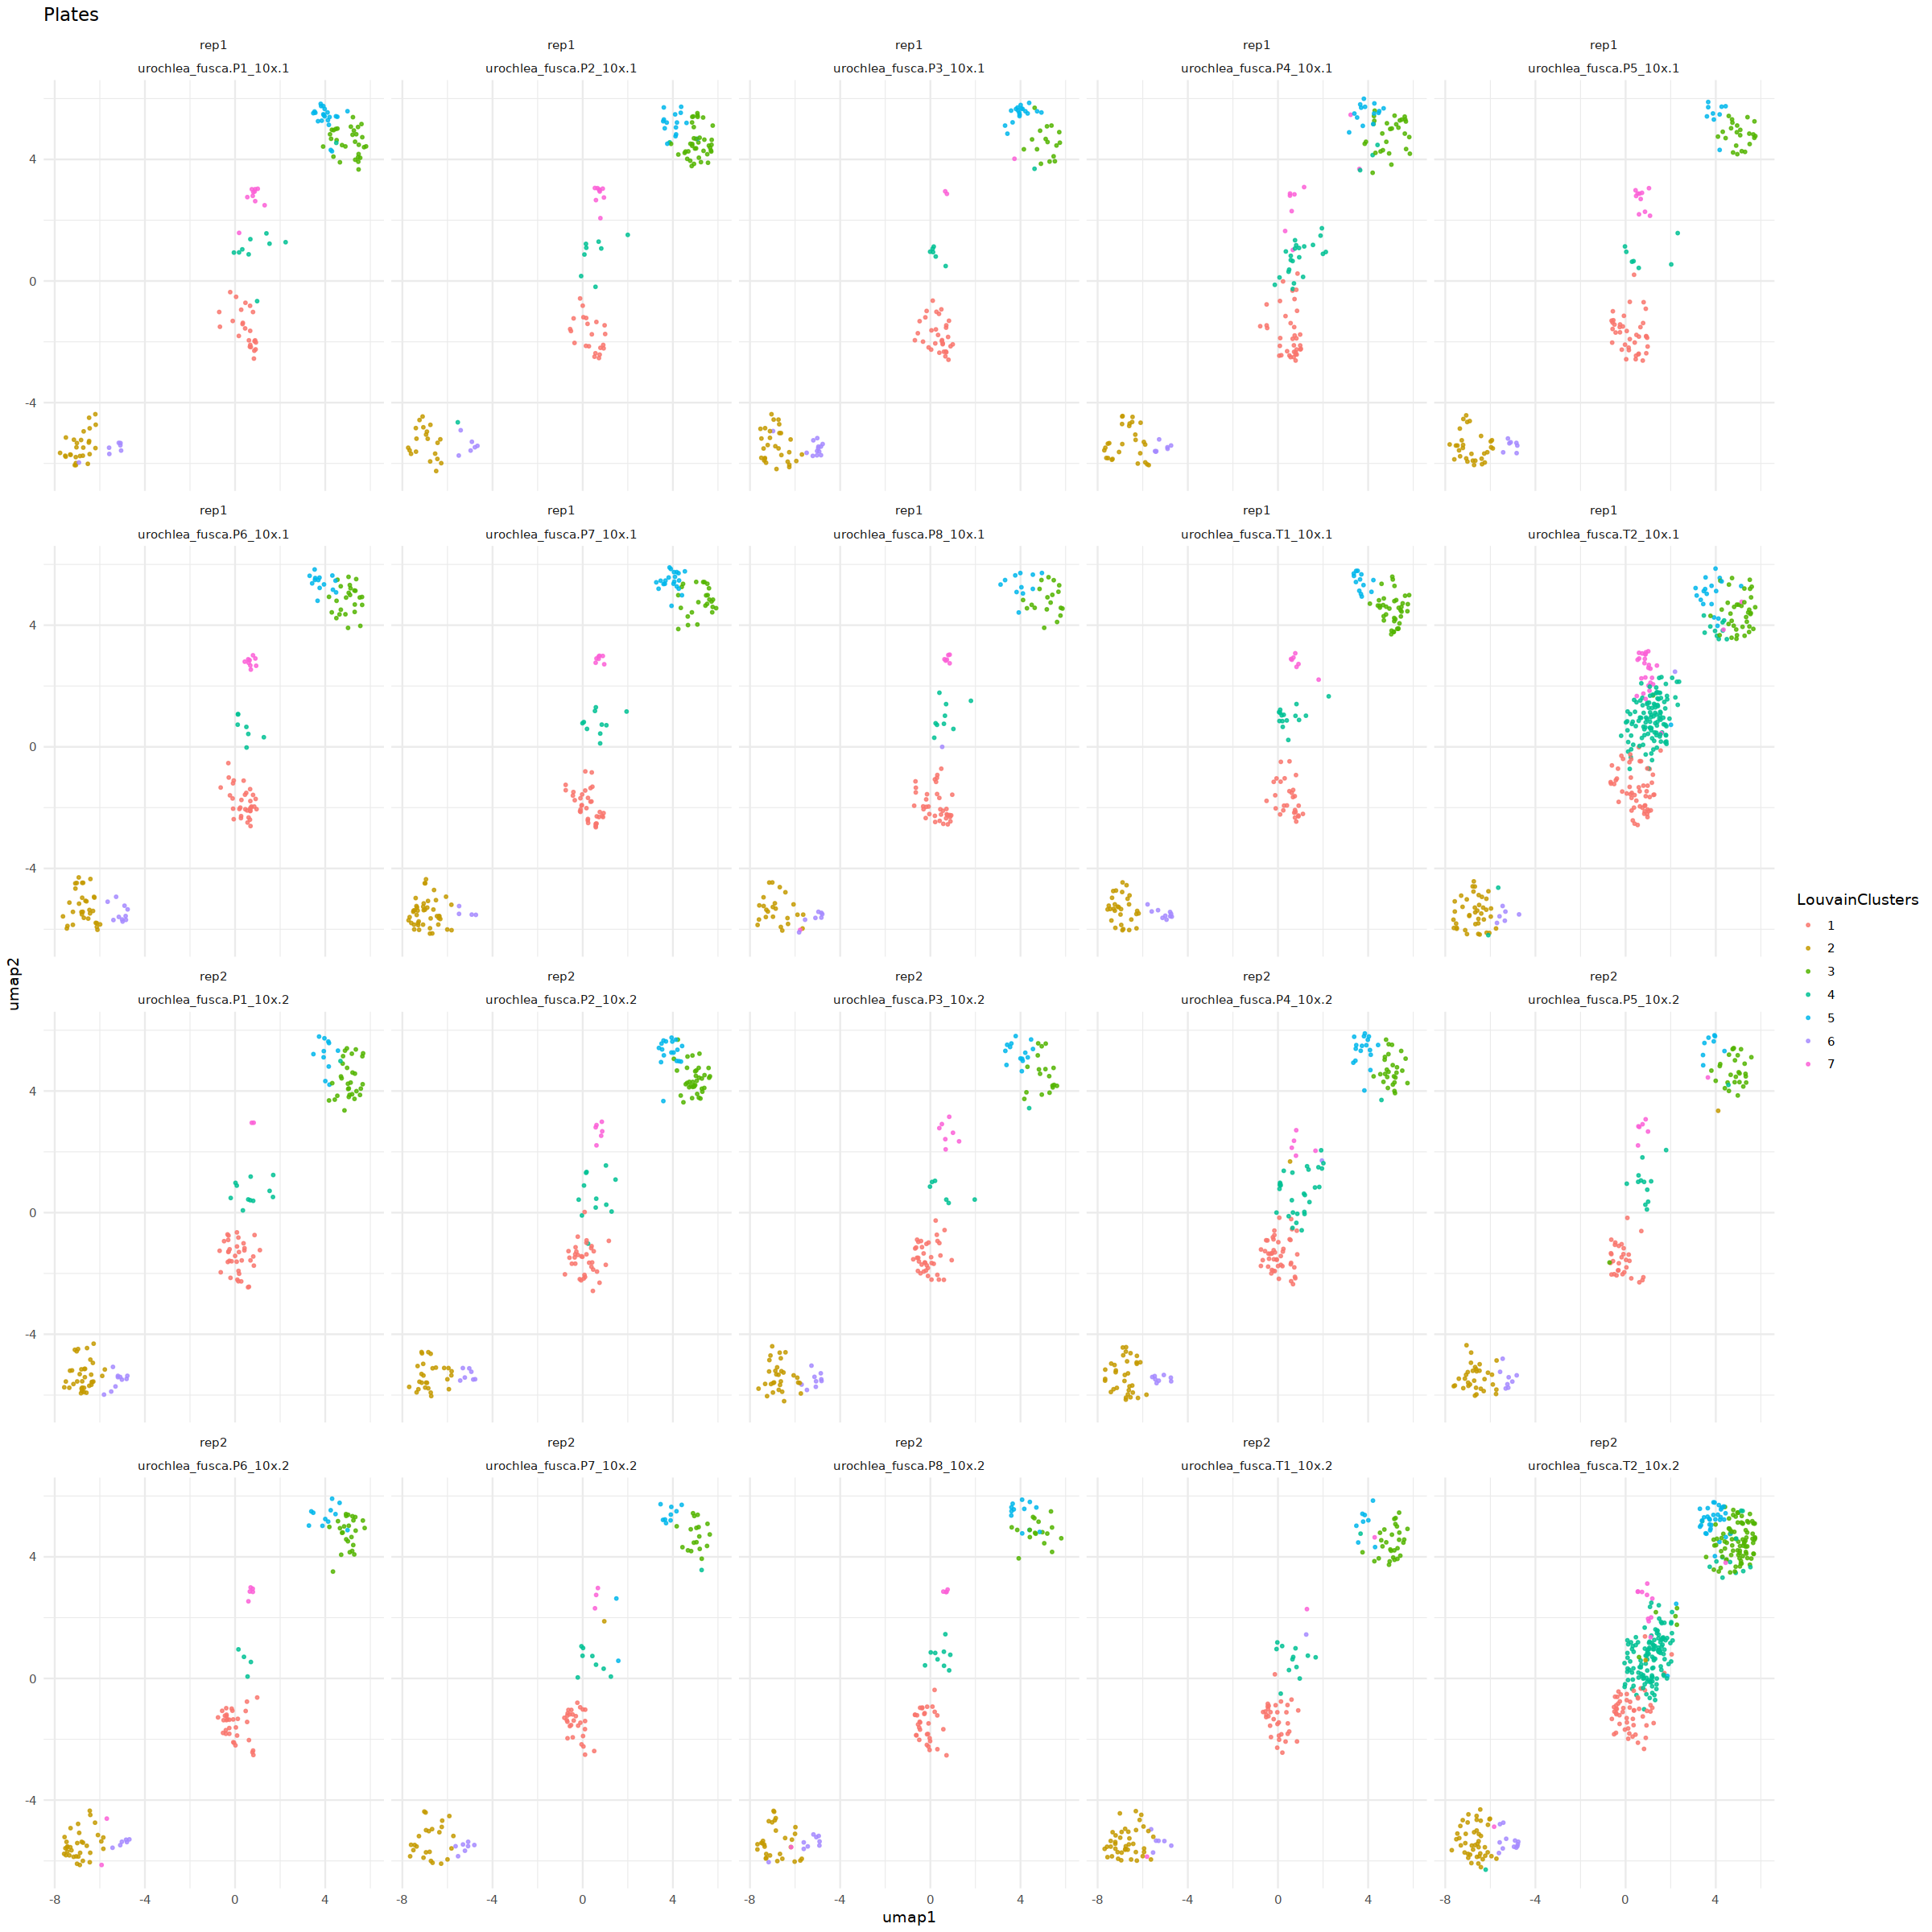

In [52]:
options(repr.plot.width=20, repr.plot.height=20)
cluster_plot  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)  %>% 
    ggplot(., aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(sampleID~plate)

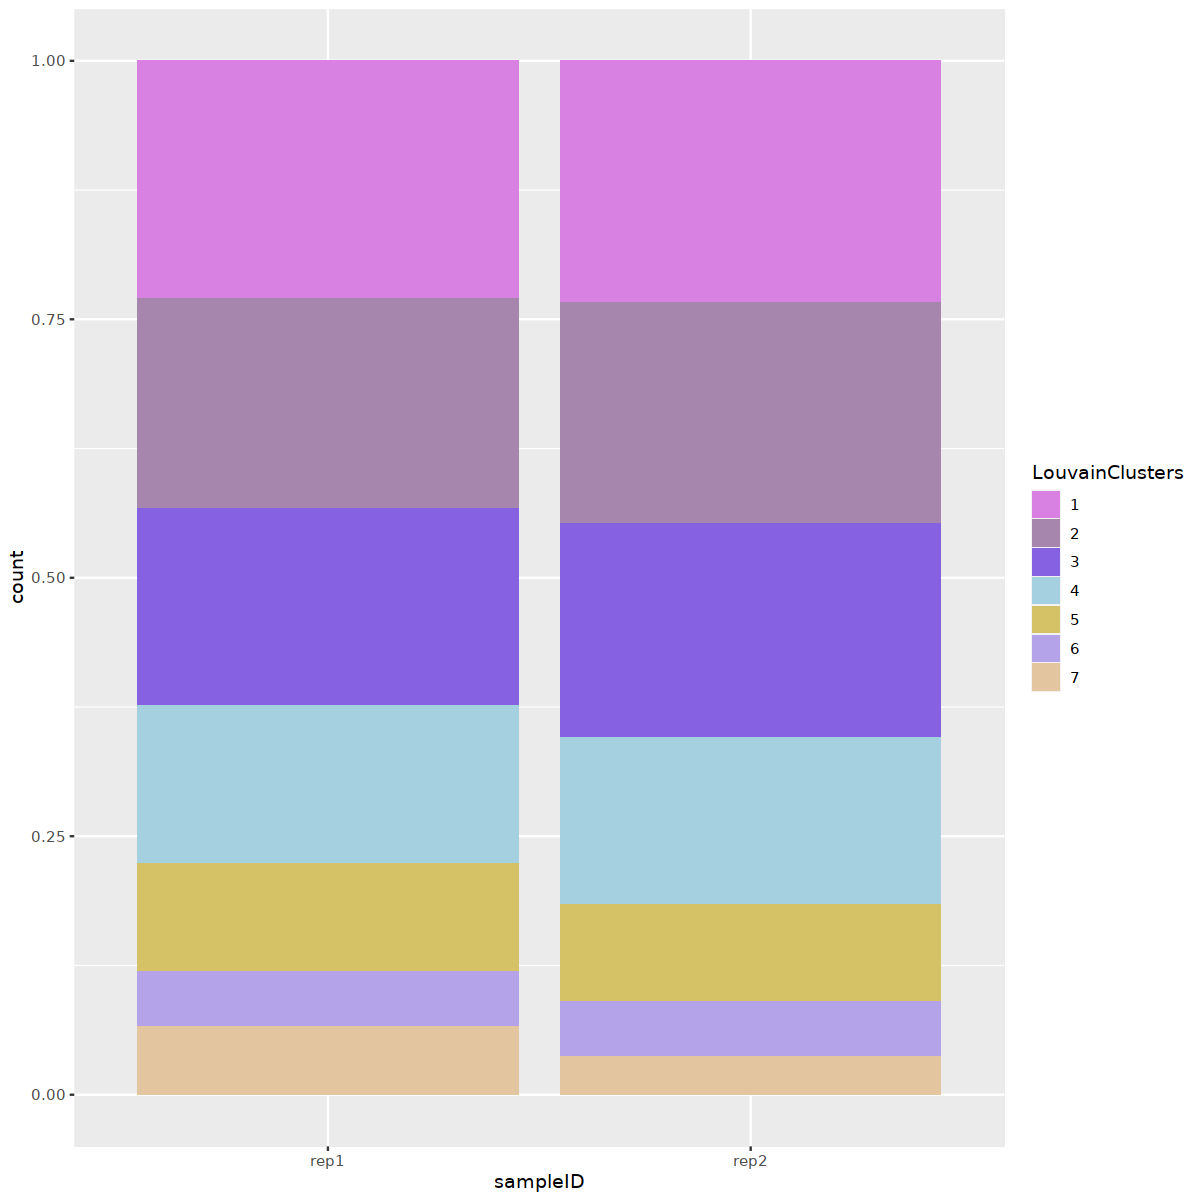

In [53]:

options(repr.plot.width=10, repr.plot.height=10)
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
#cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cluster_plot,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)


In [54]:
clusters_by_replicate <- cluster_plot  %>% 
    group_by(LouvainClusters, sampleID)  %>% 
    summarise(counts = n())

clusters_prop <- cluster_plot  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(total_cluster = n())


clusters_full_joined <- full_join(clusters_by_replicate, clusters_prop, by = c("LouvainClusters"))  %>% 
    mutate(prop_cluster = counts/total_cluster)

clusters_full_joined

`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


LouvainClusters,sampleID,counts,total_cluster,prop_cluster
<fct>,<chr>,<int>,<int>,<dbl>
1,rep1,341,705,0.4836879
1,rep2,364,705,0.5163121
2,rep1,303,636,0.4764151
2,rep2,333,636,0.5235849
3,rep1,283,604,0.4685430
3,rep2,321,604,0.5314570
4,rep1,227,478,0.4748954
4,rep2,251,478,0.5251046
5,rep1,155,301,0.5149502



Attaching package: 'patchwork'


The following object is masked from 'package:cowplot':

    align_plots


The following object is masked from 'package:MASS':

    area


Warning message:
"Removed 37 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 37 rows containing non-finite values (`stat_boxplot()`)."


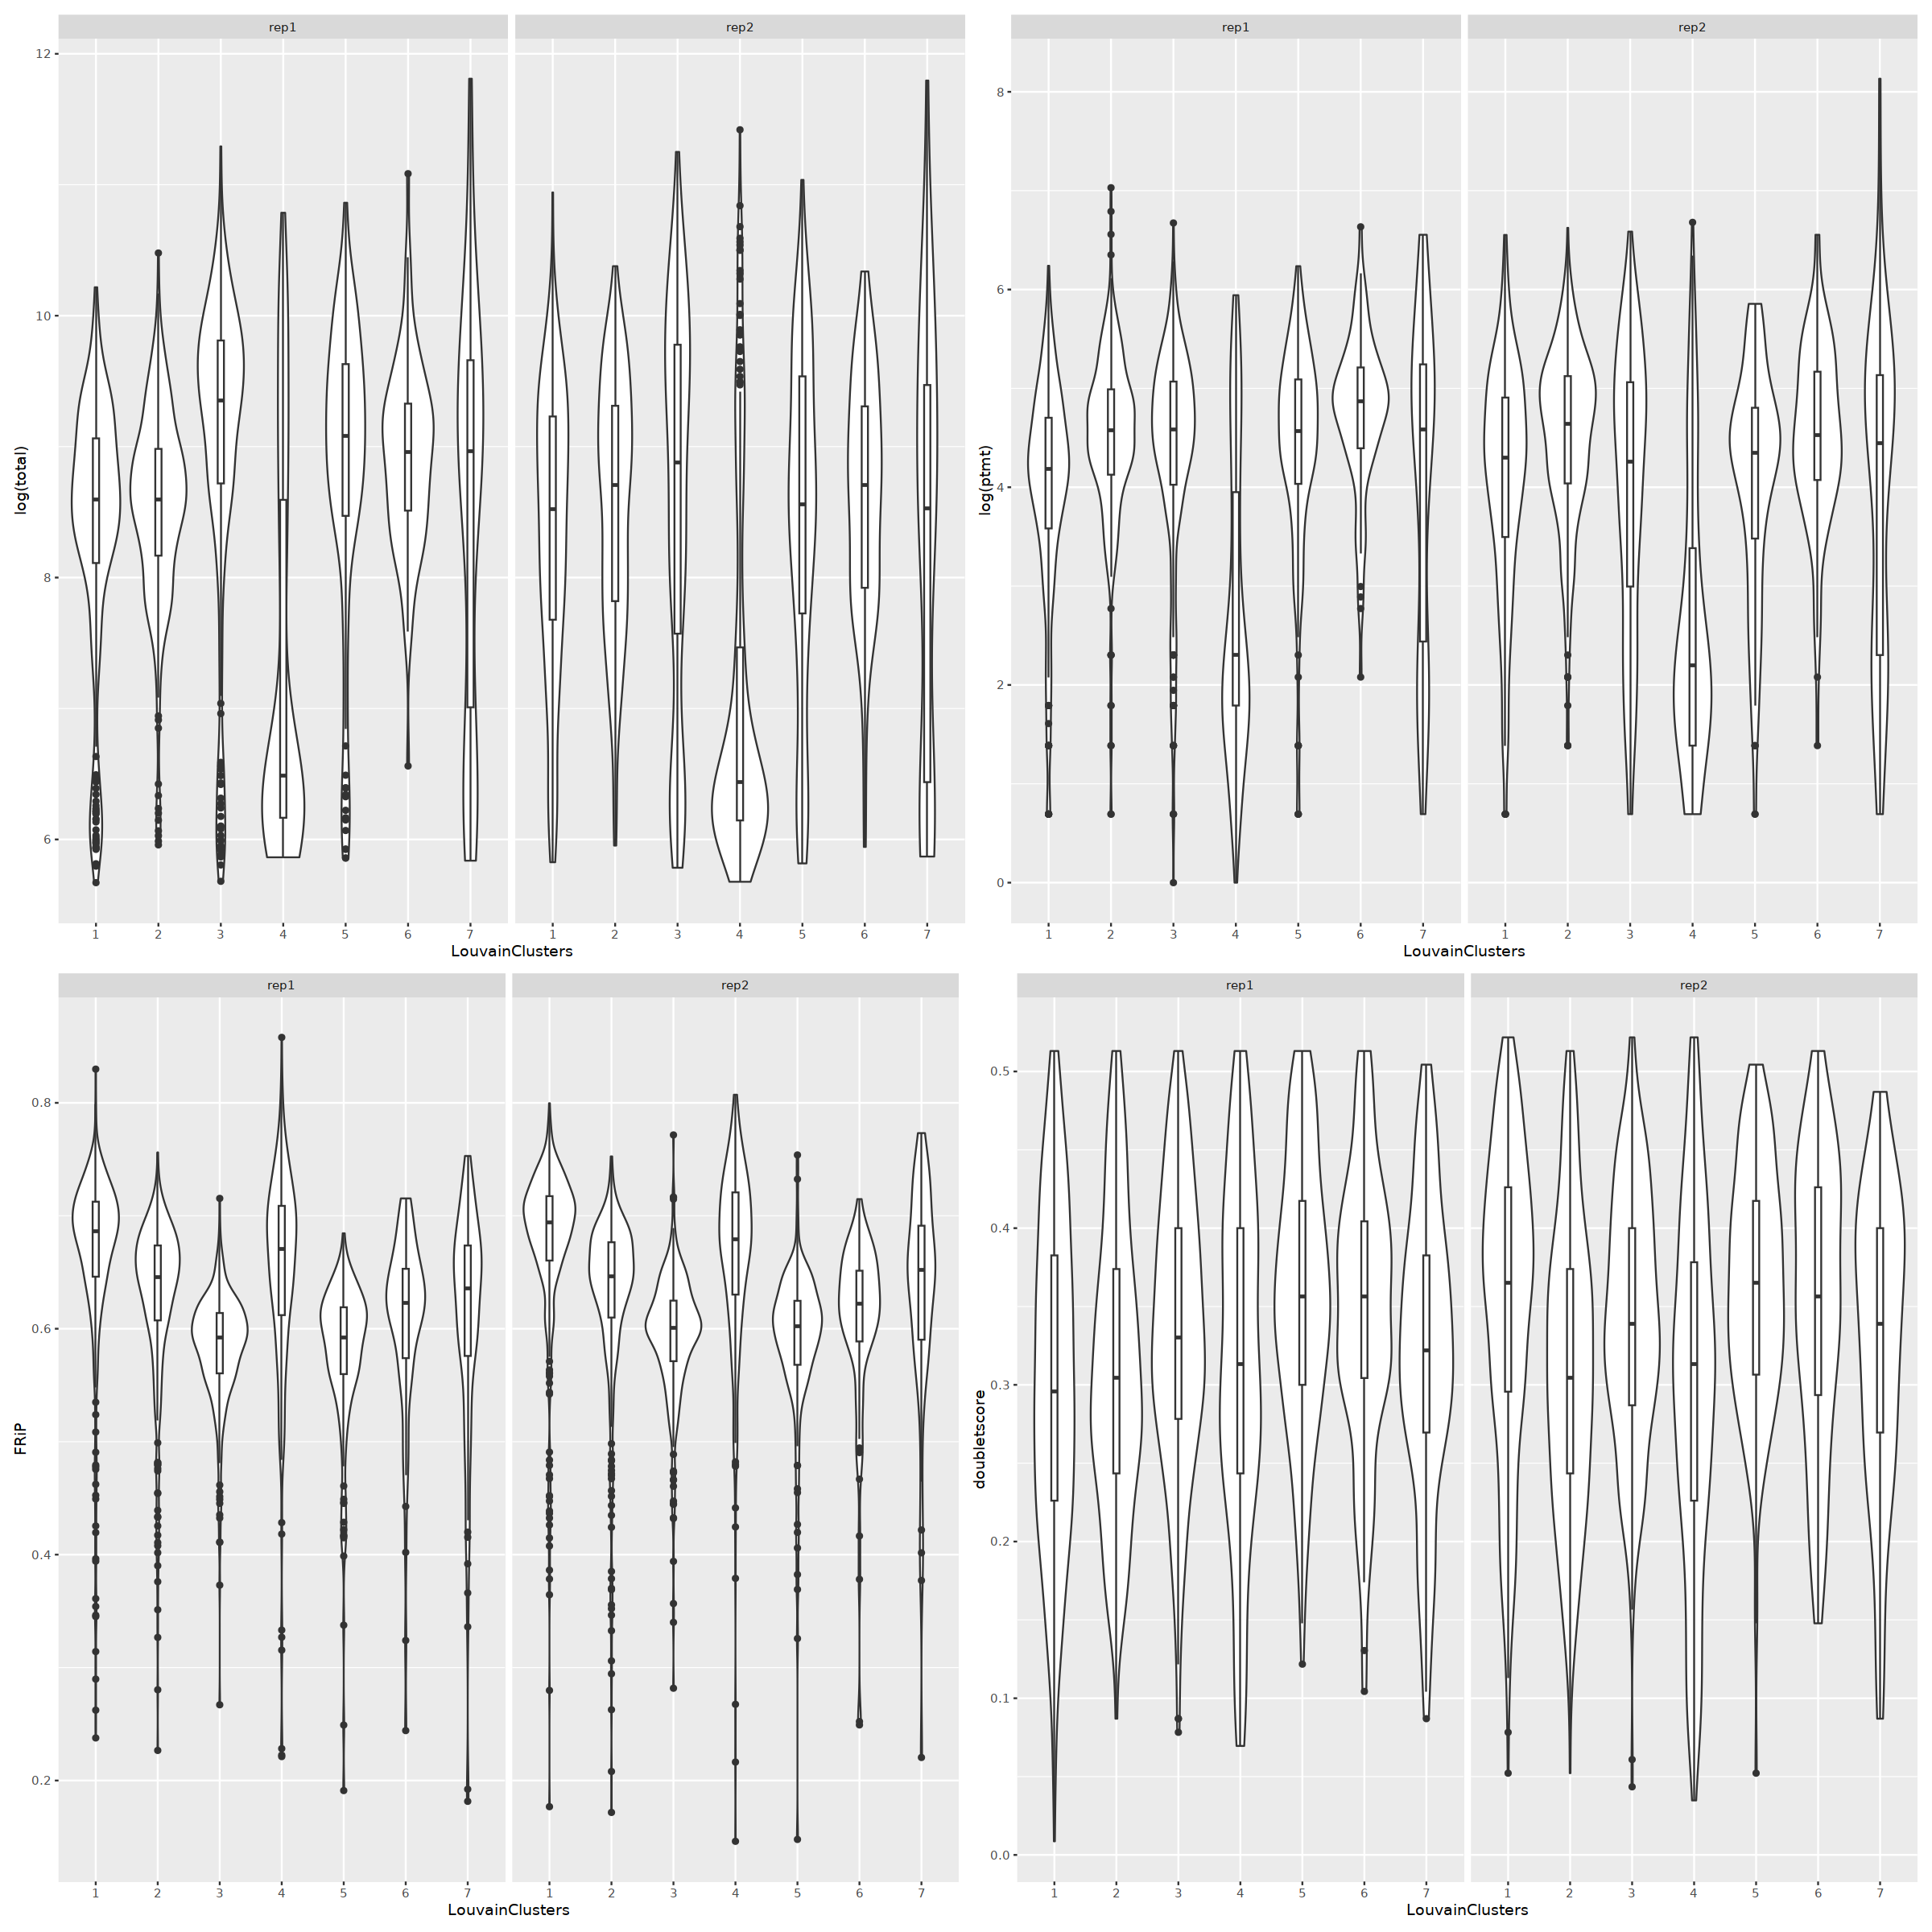

In [55]:
library(patchwork)

options(repr.plot.width=20, repr.plot.height=20)
total <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(total))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)


ptmt <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(ptmt))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

tss <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = tss)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)
 

frip <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = FRiP)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

doub <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = doubletscore)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

(total + ptmt) / (frip + doub)

# Running Presto and Cluster Correlation on LCs
## 4/3/2023

In [56]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}

In [57]:
library(tidyverse)
#pm_meta_data <- read_delim("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusca/clustering/Pm_leaf.merged_replicates.SVD.full.metadata.txt", skip = 1,
#                           col_names =  c("row_n",'cellID', 'total', 'tss', 'acrs', 'ptmt', 'nSites', 'log10nSites', 'pTSS', 'FRiP', 'pOrg', 'tss_z', 'acr_z', 'sites_z', 'qc_check', 'background', 'cellbulk', 'is_cell', 'sampleID', 'umap1', 'umap2', 'doubletscore', 'd.type', 'LouvainClusters'))
uf_gene_counts <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/urochloa_fusca/acc_metrics_leaf_clustering/urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt" 
urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters$acr_counts_raw <- uf_gene_counts

In [58]:
library(presto)
urochloa_fusca.leaf.rep1.subcluster.presto <- run_presto(urochloa_fusca.leaf.rep1.subcluster.clean.tfidf.clusters,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 24
  cellID   total   tss  acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg  tss_z
  <chr>    <int> <int> <int> <int>  <dbl>       <dbl> <dbl> <dbl>   <dbl>  <dbl>
1 BC:Z:T… 134532 74088 81810   413  38929        4.59 0.551 0.608 0.00307 0.311 
2 BC:Z:C… 100369 50764 52117   516  38454        4.58 0.506 0.519 0.00514 0.0685
3 BC:Z:A…  89967 45551 42667   563  37093        4.57 0.506 0.474 0.00626 0.0714
4 BC:Z:G… 105977 55688 59460   649  36293        4.56 0.525 0.561 0.00612 0.175 
5 BC:Z:G…  80247 42164 45508   791  29583        4.47 0.525 0.567 0.00986 0.175 
6 BC:Z:A…  65156 34702 37550   761  26068        4.42 0.533 0.576 0.0117  0.213 
# ℹ 13 more variables: acr_z <dbl>, sites_z <dbl>, qc_check <int>,
#   background <dbl>, cellbulk <dbl>, is_cell <int>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name           barcode                                

In [60]:
grabbed_top_marker_per_cluster <- top_markers(urochloa_fusca.leaf.rep1.subcluster.presto$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(urochloa_fusca.leaf.rep1.subcluster.presto$sub_cluster$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           marker_list_uf, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

rank,geneID,chr,start,stop,gene_name,cell_type,LC_value
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
17,Urofu.7G197300.v1.1,Chr07,22236736,22239131,nactf36,pith_parenchyma,LC_6
58,Urofu.5G178200.v1.1,Chr05,10053948,10056209,Zm00001eb154120_pval_0_epidermis,epidermis,LC_6
120,Urofu.7G239500.v1.1,Chr07,24840040,24846138,ocl2,"peripheral_zone_SAM,upper_floral_meristem,lower_floral_meristem",LC_6
134,Urofu.9G357700.v1.1,Chr09,30527728,30532583,Zm00001eb022580_pval_0_bundle_sheath,bundle_sheath,LC_6
rank,geneID,chr,start,stop,gene_name,cell_type,LC_value
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Urofu.2G217100.v1.1,Chr02,23850265,23856855,gl1,epidermis,LC_1
1,Urofu.2G217100.v1.1,Chr02,23850265,23856855,Zm00001eb313510__pval_0_epidermis__pval_0_protoderm,epidermis,LC_1
2,Urofu.9G538000.v1.1,Chr09,42511556,42513056,Zm00001eb006930_pval_0_epidermis,epidermis,LC_1


In [61]:
gathered_markers <- bind_rows(represented_marker_lst)  %>% 
    arrange(LC_value, rank)

gathered_markers

rank,geneID,chr,start,stop,gene_name,cell_type,LC_value
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Urofu.2G217100.v1.1,Chr02,23850265,23856855,gl1,epidermis,LC_1
1,Urofu.2G217100.v1.1,Chr02,23850265,23856855,Zm00001eb313510__pval_0_epidermis__pval_0_protoderm,epidermis,LC_1
2,Urofu.9G538000.v1.1,Chr09,42511556,42513056,Zm00001eb006930_pval_0_epidermis,epidermis,LC_1
8,Urofu.5G247900.v1.1,Chr05,14289637,14296580,Zm00001eb159140_pval_0_epidermis,epidermis,LC_1
14,Urofu.5G086100.v1.1,Chr05,4822609,4827919,Zm00001eb147400_pval_0_epidermis,epidermis,LC_1
17,Urofu.8G170600.v1.1,Chr08,24657002,24661030,Zm00001eb167740__pval_0_epidermis__pval_0_protoderm,epidermis,LC_1
37,Urofu.9G547100.v1.1,Chr09,43015202,43019523,Zm00001eb006020_pval_0_epidermis,epidermis,LC_1
45,Urofu.3G387600.v1.1,Chr03,31757898,31760161,Zm00001eb264170_pval_0_epidermis,epidermis,LC_1
50,Urofu.9G330400.v1.1,Chr09,28326885,28333607,ocl4,"protoderm,L1_SAM,L1_leaf_primordia,trichome,L1_inflorescence_meristem,L1_spikelet_pair_meristem,L1_spikelet_meristem,L1_upper_floral_meristem,L1_lower_floral_meristem,L1_pistil_primordia,L1_stamen_primordia,L1_palea_primordia,L1_lemma_primordia,L1_glume_primordia,L1_branch_meristem",LC_1


In [62]:
library(edgeR)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")

marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    
    raw_cpm_counts_all_genes <- read_delim(sparse_matrix, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
        dplyr::mutate(cellID = barcode)  %>%
        dplyr::mutate(geneID = gene_name)

    merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()


    caught_values <- as_tibble(catch)

    see <- ungroup(merged_meta_cpm_information_copied)
    idk <- bind_cols(merged_meta_cpm_information_copied,caught_values)  
    print(head(idk))
    
    merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        ungroup()  %>% 
        dplyr::rename(grouped_CPM = value)  %>% 
        dplyr::group_by(!!sym(cluster_name)) %>%  
        dplyr::mutate(log_cpm  = log(grouped_CPM))


    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

    cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
        dplyr::ungroup()  %>% 
        dplyr::select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)
    
    meta_obj[["corr_matrix"]] <- cell_type_accessability
    
    return(meta_obj)
}


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA


ℹ Loading preprocessCore


# A tibble: 6 × 24
  cellID   total   tss  acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg  tss_z
  <chr>    <int> <int> <int> <int>  <dbl>       <dbl> <dbl> <dbl>   <dbl>  <dbl>
1 BC:Z:T… 134532 74088 81810   413  38929        4.59 0.551 0.608 0.00307 0.311 
2 BC:Z:C… 100369 50764 52117   516  38454        4.58 0.506 0.519 0.00514 0.0685
3 BC:Z:A…  89967 45551 42667   563  37093        4.57 0.506 0.474 0.00626 0.0714
4 BC:Z:G… 105977 55688 59460   649  36293        4.56 0.525 0.561 0.00612 0.175 
5 BC:Z:G…  80247 42164 45508   791  29583        4.47 0.525 0.567 0.00986 0.175 
6 BC:Z:A…  65156 34702 37550   761  26068        4.42 0.533 0.576 0.0117  0.213 
# ℹ 13 more variables: acr_z <dbl>, sites_z <dbl>, qc_check <int>,
#   background <dbl>, cellbulk <dbl>, is_cell <int>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>


Rows: 73649352 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


# A tibble: 6 × 4
# Groups:   LouvainClusters [1]
  LouvainClusters geneID              counts  value
  <fct>           <chr>                <dbl>  <dbl>
1 1               Urofu.1G000100.v1.1    487  69.2 
2 1               Urofu.1G000200.v1.1   1491 212.  
3 1               Urofu.1G000300.v1.1    641  91.1 
4 1               Urofu.1G000400.v1.1    138  19.6 
5 1               Urofu.1G000500.v1.1     64   9.09
6 1               Urofu.1G000600.v1.1      8   1.14


Selecting by resid


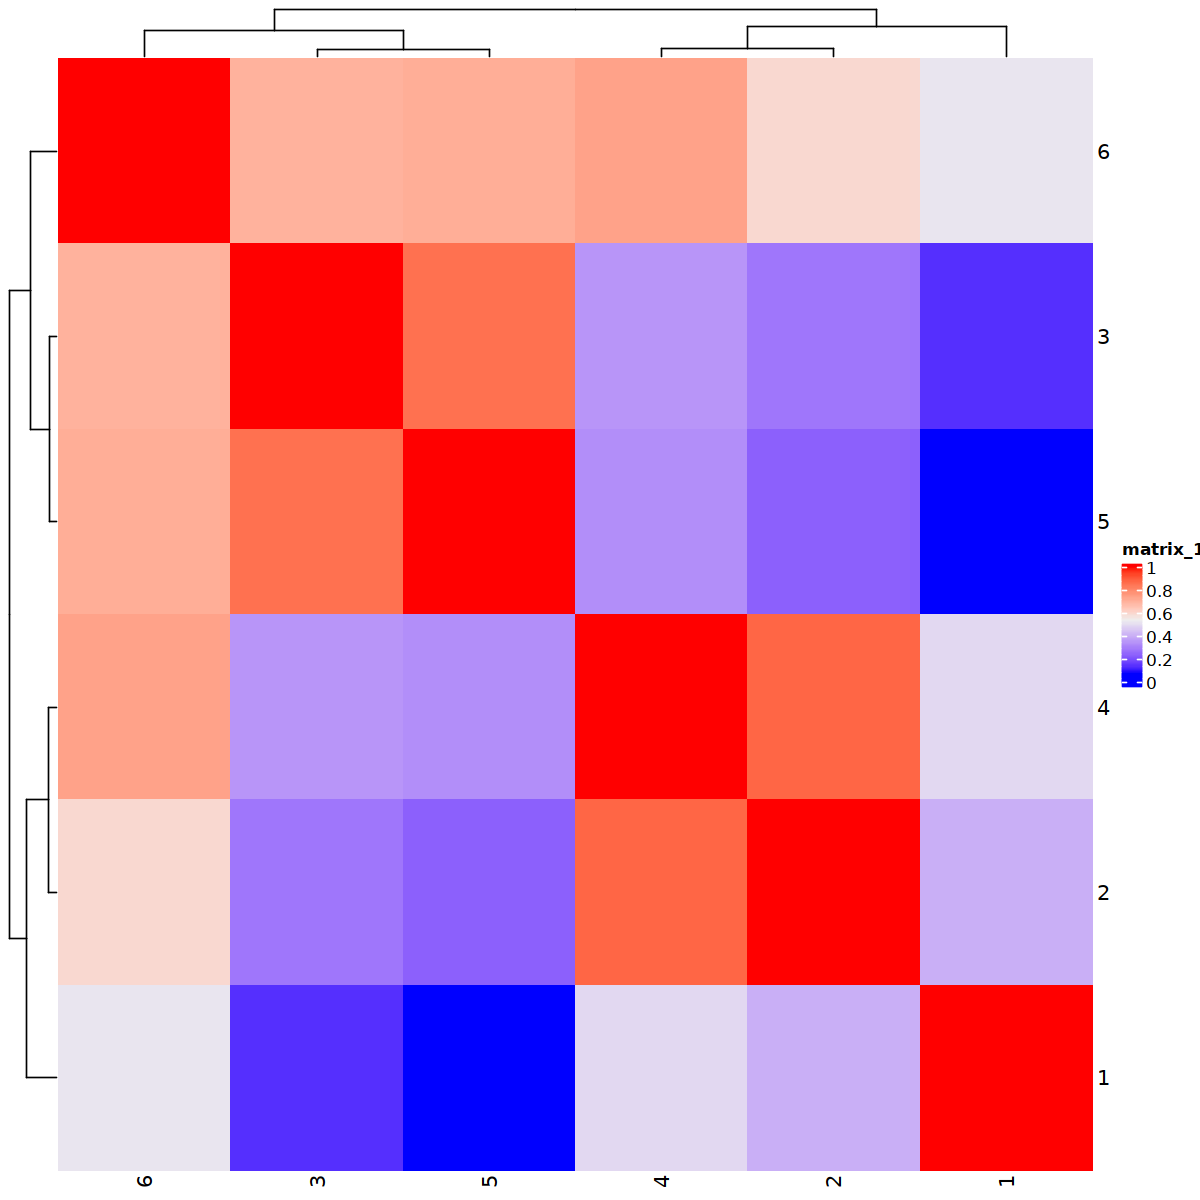

In [66]:
urochloa_fusca.leaf.corr <- marker_correlation(urochloa_fusca.leaf.rep1.subcluster.presto,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

library(modelr)
combined_louvain_clusters <- as_tibble(urochloa_fusca.leaf.corr$corr_matrix) %>%
    pivot_longer(!geneID, names_to = "cluster_name", values_to = "score")  %>% 
    group_by(geneID)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_louvain_clusters)

combined_louvain_clusters.final <- combined_louvain_clusters %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(100)

options(repr.plot.width=10, repr.plot.height=10)
corr_matrix <- urochloa_fusca.leaf.corr$corr_matrix

viz_matrix <- as_tibble(corr_matrix)  %>% 
    dplyr::filter(geneID %in% combined_louvain_clusters.final$geneID)  %>% 
    dplyr::select(-geneID)

Lc_corr_matrix <- cor(data.matrix(viz_matrix))

suppressPackageStartupMessages(library(ComplexHeatmap))
library(ComplexHeatmap)
Heatmap(Lc_corr_matrix)

In [70]:
prefix <- "Uf_leaf.merged_replicates.Subclustering"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/clustering/"

# output text files
nmf.meta <- urochloa_fusca.leaf.rep1.subcluster.presto$sub_cluster
nmf.rd <- urochloa_fusca.leaf.rep1.subcluster.presto$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(urochloa_fusca.leaf.rep1.subcluster.presto$counts))
trip$i <- rownames(urochloa_fusca.leaf.rep1.subcluster.presto$counts)[trip$i]
trip$j <- colnames(urochloa_fusca.leaf.rep1.subcluster.presto$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")
saveRDS(urochloa_fusca.leaf.rep1.subcluster.presto, file = paste0(output_location, prefix, ".rds"))